# 解编码过程总结
***最终的编码过程如下：***
- $z \in C^{N/2}$
- $\pi^{-1}(z) \in \mathbb{H}$
- $\Delta \pi^{-1}(z)$
- 投射到$\sigma(R)$中：$\lfloor \Delta \cdot \pi(z) \rceil_{\sigma(R)} \in \sigma(R)$
- 用$\sigma$进行编码：$m(X)=\sigma^{-1}(\lfloor \Delta \cdot \pi(z) \rceil_{\sigma(R)}) \in R$

***最终的解码过程如下：***
$z=\pi \circ \sigma(\Delta^{-1}\cdot m)$

# 典范嵌入及其实现
## canonical embedding 典范嵌入
典范嵌入是一类泛指的嵌入，指的是 ***原环元素在扩张结构中的”自然对应“***

简单的典范嵌入有$Z->Q$

我们处理的典范嵌入则是如下图所示：
$$
\sigma:C[X]/(X^{N}+1)=>C^{N}
$$
典范嵌入将分圆多项式$\Phi_{M}(X)=X^{N}+1$的各个根$\xi,\xi^{3},...,\xi^{2N-1}$带入目标多项式$C[X]/(X^{N}+1)$中逐个evaluate，然后得到的根组合成$C^{N}$
也即：
$$
\begin{aligned}
\sigma(m)&=(m(\xi),m(\xi^{3}),...,m(\xi^{2N-1}))\\
&= (z_{1},...,z_{N})
\end{aligned}
$$
注意，这里的根是从1到2N-1而不是N的

典范嵌入σ定义了一个同构（也就是说它定义了一个双射同态），在计算上它是同态的，在映射上是双射的

### 分圆多项式的根
$$
\phi_{n}(x)=\prod\limits_{1\le k\le n,gcd(k,n)=1}(x-e^{2i\pi \frac{k}{n}})
$$

当$N=2^{k}$时，有
$$
\phi_{2N}(X)=X^{N}+1
$$

### 双射的说明
已知：
$$m(X)=\sum\limits_{i=0}^{N-1}=\alpha_{i}X^{i} \in C[X]/(X^{N}+1)$$
评估是如下进行的：
$$\sum\limits_{j=0}^{N-1}\alpha(\xi^{2i-1})^{j}=z_{i},i=1,...,N$$

因此我们可以将其看作一个矩阵乘法：
$$A\alpha=z$$

由于A是一个范德蒙矩阵，且构成$x$的根各不相同，因此存在逆矩阵

In [1]:
# 以下是典范嵌入的代码实现
import numpy as np
from math import gcd

M = 8
assert(M & (M - 1) == 0), "M必须是2的幂次方"
N = M // 2 
vectors = np.array([1, 2, 2, 2])

# 构造典范嵌入相关的矩阵
roots = [np.exp(2j * np.pi * k / M) for k in range(M) if gcd(k, M) == 1] # 通过分园多项式结论得知：该式子得到X^N+1对应的所有单位根(M=2N)

A = np.array([[root ** i for i in range(N)] for root in roots])

# 应用典范嵌入逆运算，将向量映射回多项式系数
poly_coeffs = np.linalg.solve(A, vectors)
print("多项式系数:", poly_coeffs)

# 验证：将多项式系数通过典范嵌入映射回向量
reconstructed_vectors = A @ poly_coeffs
print("重构向量:", reconstructed_vectors)


多项式系数: [ 1.75000000e+00+7.96951489e-17j -1.76776695e-01+1.76776695e-01j
 -7.63278329e-17+2.50000000e-01j  1.76776695e-01+1.76776695e-01j]
重构向量: [1.-8.12941988e-18j 2.+5.61862510e-17j 2.+6.70078871e-17j
 2.+1.03204047e-16j]


In [2]:
# 调用encoding模块中的函数进行编码和解码
from encoding import SimpleEncoding
import numpy as np

M = 8
# 测试加法和乘法同态
encoder = SimpleEncoding(M)
v1 = np.array([1, 2, 3, 4])
v2 = np.array([5, 6, 7, 8])

modulo = np.polynomial.Polynomial([1] + [0]*(M//2 - 1) + [1])  # X^N + 1

ct1 = encoder.sigma_inv(v1)
ct2 = encoder.sigma_inv(v2)

ct_add = ct1 + ct2
# 考虑到多项式相乘，最大项会超出范围，因此我们需要对其进行模X^N+1的约简
ct_mul = (ct1 * ct2) % modulo

decoded_add = encoder.sigma(ct_add)
decoded_mul = encoder.sigma(ct_mul)

print(f"Added ciphertexts decoded: {decoded_add} (expected: {v1 + v2})") # 实际上并不是密文，只是这么叫而已
print(f"Multiplied ciphertexts decoded: {decoded_mul} (expected: {v1 * v2})")

print(f"Add norm: {np.linalg.norm(decoded_add - (v1 + v2))}")
print(f"Mul norm: {np.linalg.norm(decoded_mul - (v1 * v2))}")

Added ciphertexts decoded: [ 6.+3.45793845e-17j  8.-2.18527158e-16j 10.+3.53998674e-16j
 12.-8.59671258e-17j] (expected: [ 6  8 10 12])
Multiplied ciphertexts decoded: [ 5.+6.34808976e-16j 12.-6.12064760e-16j 21.+2.39285973e-15j
 32.+1.27112551e-15j] (expected: [ 5 12 21 32])
Add norm: 4.26210347928688e-16
Mul norm: 3.3577651883537623e-15


# $Z[X]/(X^N+1)$上的典范嵌入
![Pasted image 20251111170719.png](<attachment:Pasted image 20251111170719.png>)

由上图的N=4的简单情况可知，分圆多项式的根实际上是对称的。
在这个例子中，有$\omega_{1}=\overline{\omega_{7}}$，$\omega_{3}=\overline{\omega_{5}}$
考虑到总数=8，我们就有了$\omega_{j}=\overline{\omega_{-j}}$

由于在$m(x) \in Z[X]$中做评估，因此就有了$m(\xi^{j})=\overline{m(\xi^{-j})}=m(\overline{\xi^{-j}})$

由于$\sigma$映射中的每一个向量元素都是由多项式在单位根上评估而来，因此我们有：
$$
\begin{align}
Z_{N}&= (z_{1},...,z_{N})\\
     &= (m(\xi),m(\xi^{3}),...,m(\xi^{2N-1})) \\
     &= (m(\xi),m(\xi^{3}),...,m(\overline{\xi^{3}}),m(\overline{\xi})) \\
     &= (z_{1},z_{2},...,\overline{z_{2}},\overline{z_{1}})
\end{align}
$$

因此，需要在实数参数的$m(x)$的情况下，评估出来的$Z_{N}$实际上自由度只有$N/2$

从典范嵌入的正方向的例子可以说明（但是不是证明），如果我们想要保证典范嵌入的逆方向$\sigma^{-1}:C^{N} \to Z[X]/(X^N+1)$，复向量映射到$Z[X]/(X^N+1)$，我们至少要保证$C^{N}$的自由度减半，也就是变为$C^{N/2}$

从以下的代码以及输出也可以看出相关的结论：我们会发现，当M=8，N=4是，如果输入vector是形如上文的$Z_{N}$的形式，那么转换出来的多项式是实数的，如果输入的vector不是这样，那么转换的多项式$m(x)\notin Z[X]$
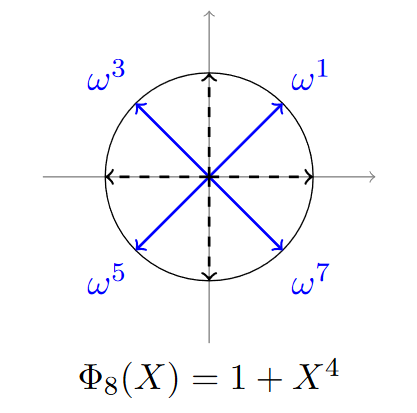

In [31]:
from encoding import SimpleEncoding

M = 8

encoder = SimpleEncoding(M)

v1 = np.array([1, 2, 2, 1])
v2 = np.array([1, 2, 2, 2])
v3 = np.array([1+1j, 2+2j, 2-2j, 1-1j])
v4 = np.array([1+1j, 2+2j, 2+2j, 1-1j])
v5 = np.array([1j, 2j, -2j, -1j])
v6 = np.array([1j, 2j, 2j, -1j])

ct1 = encoder.sigma_inv(v1)
ct2 = encoder.sigma_inv(v2)
ct3 = encoder.sigma_inv(v3)
ct4 = encoder.sigma_inv(v4)
ct5 = encoder.sigma_inv(v5)
ct6 = encoder.sigma_inv(v6)

def is_effectively_real(x, tol=1e-15):
    x = np.asarray(x)
    return np.all(np.abs(np.imag(x)) < tol)

print(f"origin: {v1} sigma^{{-1}} is real: {is_effectively_real(ct1.coef)}")
print(f"origin: {v2} sigma^{{-1}} is real: {is_effectively_real(ct2.coef)}")
print(f"origin: {v3} sigma^{{-1}} is real: {is_effectively_real(ct3.coef)}")
print(f"origin: {v4} sigma^{{-1}} is real: {is_effectively_real(ct4.coef)}")
print(f"origin: {v5} sigma^{{-1}} is real: {is_effectively_real(ct5.coef)}")
print(f"origin: {v6} sigma^{{-1}} is real: {is_effectively_real(ct6.coef)}")

origin: [1 2 2 1] sigma^{-1} is real: True
origin: [1 2 2 2] sigma^{-1} is real: False
origin: [1.+1.j 2.+2.j 2.-2.j 1.-1.j] sigma^{-1} is real: True
origin: [1.+1.j 2.+2.j 2.+2.j 1.-1.j] sigma^{-1} is real: False
origin: [ 0.+1.j  0.+2.j -0.-2.j -0.-1.j] sigma^{-1} is real: True
origin: [ 0.+1.j  0.+2.j  0.+2.j -0.-1.j] sigma^{-1} is real: False


# $\pi$操作
$$
\begin{align}
&\pi: \mathbb{H}\to C^{\phi(M)/2} \\
&where~\mathbb{H}=\{(z_{j})_{j \in\mathbb{Z^{*}_{M}}}:z_{j}=\overline{z_{-j}},\forall j \in Z^{*}_{M}\} \in \mathbb{C}^{\phi(M)}
\end{align}
$$

其中$z_{j}$与$z_{-j}$可以参考上文的$\omega$，只不过这里指的是向量的元素
$Z^{*}_{M}$表示的是模$M$乘法群，包含了所有与$M$互素的元素

$\phi(M)$表示$M$的欧拉函数，也就是说，表示所有与$M$互素的函数个数，在$M$是2的幂次的情况下，$\phi(M)=\frac{M}{2}$

因此$\pi$操作实际上表示的是将原先的$C^{N}$映射到$C^{N/2}$中，其更加详细的数学表述如下：
$$
\begin{align}
&\pi(Z) = (z_j)_{j \in S}, \\
&where~S = \{ j \in \mathbb{Z}_M^* \mid 1 \le j < M/2 \}
\end{align}
$$

## 示例： $M=8$ (对应 $\Phi_8(X)$)

用$M=8, N=\phi(M)=4$来演示这个流程：

1. **索引集：** $\mathbb{Z}_8^* = \{1, 3, 5, 7\}$。
2. **划分：**
    - $j=1 \implies -j=7 \pmod 8$。 配对：$\{1, 7\}$。
    - $j=3 \implies -j=5 \pmod 8$。 配对：$\{3, 5\}$。
3. **代表集：** 我们按规范选择 $S = \{ j \in \mathbb{Z}_8^* \mid 1 \le j < 8/2=4 \} = \{1, 3\}$。
    - $S$ 的大小为 $|S|=2$，这等于 $\phi(8)/2 = 4/2 = 2$。
4. **$\pi$ 操作：**
    - $\mathbb{H}$ 中的一个向量是 $Z = (z_1, z_3, z_5, z_7)$。
    - 它满足 $z_5 = \overline{z_{-5}} = \overline{z_3}$ 且 $z_7 = \overline{z_{-7}} = \overline{z_1}$。
    - 因此， $Z = (z_1, z_3, \overline{z_3}, \overline{z_1})$。
    - $\pi$ 操作提取由 $S=\{1, 3\}$ 索引的分量。

$$\pi(Z) = \pi( (z_1, z_3, z_5, z_7) ) = (z_1, z_3)$$

这个 $(z_1, z_3)$ 向量就在 $\mathbb{C}^{\phi(8)/2} = \mathbb{C}^2$ 空间中。


# $\pi^{-1}$
也就是$\pi$的逆操作，参考上文应该已经可以很好的理解了
***$\pi^{-1}$ 的工作是：***
1. 接收一个 $\phi(M)/2$ 维的复向量 $v$。
2. 用 $v$ 的分量来**填充** $\mathbb{H}$ 向量的“前半部分”（由代表集 $S$ 索引）。
3. 使用共轭对称性 $z_j = \overline{z_{-j}}$ 来**计算并填充** $\mathbb{H}$ 向量的“后半部分”。

## $\pi^{-1}$ 示例操作
$M=8$ (对应 $\Phi_8(X)$)
- **输入空间：** $\mathbb{C}^{\phi(M)/2} = \mathbb{C}^2$
- **输出空间：** $\mathbb{H} \subset \mathbb{C}^4$
- **索引集：** $\mathbb{Z}_8^* = \{1, 3, 5, 7\}$
- **代表集 (S)：** $S = \{1, 3\}$
- **对称规则：** $z_5 = \overline{z_{-5}} = \overline{z_3}$ ； $z_7 = \overline{z_{-7}} = \overline{z_1}$

假设我们从 $\mathbb{C}^2$ 中选取一个任意的输入向量 $v$：
$$v = (v_1, v_2) = (1 + 2i, \quad 3 - 4i)$$
我们要计算 $Z = \pi^{-1}(v)$。$Z$ 是一个 4 维向量 $Z = (z_1, z_3, z_5, z_7)$。
1. 填充前半部分 (由 S={1, 3} 索引)：
    我们将 $v$ 的分量直接赋给 $Z$ 中由 $S$ 索引的位置。
    - $z_1 = v_1 = \mathbf{1 + 2i}$
    - $z_3 = v_2 = \mathbf{3 - 4i}$
2. 计算后半部分 (由 {5, 7} 索引)：
    我们使用共轭对称规则来计算 $z_5$ 和 $z_7$。
    - 计算 $z_5$：
        $z_5 = \overline{z_3} = \overline{(3 - 4i)} = \mathbf{3 + 4i}$
    - 计算 $z_7$：
        $z_7 = \overline{z_1} = \overline{(1 + 2i)} = \mathbf{1 - 2i}$
1. 组合结果：
    我们得到了完整的 $\mathbb{H}$ 空间向量 $Z$：
    $$Z = (z_1, z_3, z_5, z_7)$$
    $$Z = (\underbrace{1 + 2i}_{z_1}, \quad \underbrace{3 - 4i}_{z_3}, \quad \underbrace{3 + 4i}_{z_5 = \overline{z_3}}, \quad \underbrace{1 - 2i}_{z_7 = \overline{z_1}})$$

In [36]:
# 以下是一个pi的简单演示
import numpy as np

def pi(z: np.ndarray, N: int) -> np.ndarray:
    # M = 2N
    return z[:N//2]

def pi_inv(v: np.ndarray, N: int) -> np.ndarray:
    # M = 2N
    v_conj_reversed = np.conj(v)[::-1]
    return np.concatenate([v, v_conj_reversed])

M = 8
N = M // 2
z = np.array([1+0j, 2+1j, 2-1j, 1-0j])
print(f"Original z: {z}")
v = pi(z, N)
print(f"pi(z): {v}")
z_reconstructed = pi_inv(v, N)
print(f"pi_inv(v): {z_reconstructed}")

Original z: [1.+0.j 2.+1.j 2.-1.j 1.+0.j]
pi(z): [1.+0.j 2.+1.j]
pi_inv(v): [1.+0.j 2.+1.j 2.-1.j 1.-0.j]


# 坐标随机舍入(coordinate-wise random rounding)
$R:Z[X]/(X^N+1)$

事实上，我们并不能直接使用$\sigma: Z[X]/(X^N+1) \to \sigma(R) \in \mathbb{H}$，这是因为$\mathbb{H}$中的元素并不一定在$\sigma(R)$中。
这一点其实可以很好的理解——$\mathbb{H}$是不可数的，而$\sigma(R)$是可数的（由于$R$是可数且与$\sigma(R)$是同态的）

因此需要找到一个方法，将$\mathbb{H}$ 映射到$\sigma(R)$

我们可以引入***坐标随机舍入***：这是一个将实数$x$随机舍入至$\lfloor x\rfloor$或者$\lfloor x \rfloor +1$，其概率取决于$x$与$\lfloor x\rfloor$或者$\lfloor x \rfloor +1$的接近程度，越接近，概率越高。

## 正交基与Hermite内积
$$
Hermitian~product: \langle a,b\rangle = \sum\limits_{i=1}^{N}x_{i}\overline{y_{i}} = b^{H}a
$$

>[!note] 
>Hermite内积也可以放在x上，两种结果都是内积且呈复共轭关系，不同领域有不同的用法


选取整数多项式($R:Z[X]/(X^N+1)$)中的一组正交基$\{1,X,...,X^{N-1}\}$

由于我们在$R$上选取了一组“正交基”，同样的，我们在$\sigma(R)$上选取出了一组正交基$\beta = (b_{1},b_{2},...,b_{N})=(\sigma(1),\sigma(X),...,\sigma(X^{N-1}))$

因此，我们的
$$
\begin{align}
z&=(z_{1},z_{2},...,z_{n}) \\
 &=\sum\limits_{i=1}^{N}z_{i}b_{i} \\
~~&with~z_{i}=\frac{\langle z,b_{i} \rangle}{\| b_{i}\|^{2}}
\end{align}
$$

因此，我们对$z_{i}$执行***坐标随机舍入***即可

### $X$是什么？为什么多项式上的内积定义是什么？为什么它们是正交的？
这里的一组基$\{1,X,...,X^{N-1}\}$在传统的定义中（使用积分定义的内积），应该是非正交的（不确定，没验证过），然而，它们能组合为$R$空间中的任意多项式，形如$\alpha_{0}+\alpha_{1}X+\dots+\alpha_{N-1}X^{N-1}$

然而，我们使用多项式系数来定义内积的话，我们会和轻易的发现，它们是正交的，比如
$[1,0,\dots,0]$表示的1，以及$[0,1,\dots,0]$表示的$X$，两者点积就等于0，而点积自身则不等于0

具体数学表述如下：
$$
\begin{align}
&\alpha_{i} = [\underbrace{0,\dots}_{i},1,\dots,0] \\
&\langle \alpha_{i},\alpha_{j} \rangle = 0,i\ne j \\
&\langle \alpha_{i},\alpha_{j} \rangle = 1,i = j
\end{align}
$$

***因此，通过多项式系数定义的点积上，它们是正交的***

而这么定义的原因，是为了保证典范嵌入后的基是正交的。我们会在后面的内容中分析.
### 为什么典范嵌入后得到的向量也是正交的呢？
回顾先前的内容，我们容易得知，典范嵌入可以表示为如下公式：
$$A\alpha=z$$
> [[#双射的说明]]

$$
Y = \{\xi,\xi^{3},\dots,\xi^{2N-1}\}^{T},where~\xi~is~a~root~of~Cyclotomic~ Polynomial~X^{N}+1
$$
我们首先证明$A=NI$，是一个对角矩阵

***引理***
考虑多项式的内积

>[!note] 
>在这里的上下文中，$\mathbf{z}^{i}=\left[z_{1}^{i}~z_{2}^{i}~\dots ~z_{n}^{i}\right]^{T}$，$\mathbf{z}$表示任一向量

$$
\begin{align}
\langle Y^{i},Y^{j} \rangle &= \sum\limits_{n=1}^{N} (\xi^{2n-1})^{i}\overline{(\xi^{2n-1})^{j}} \\
&= \sum\limits_{n=1}^{N} (\xi^{2n-1})^{i}(\xi^{2n-1})^{-j} \\
&= \sum\limits_{n=1}^{N}\xi^{(2n-1)(i-j)} \\
\end{align}
$$

由于$\xi=e^{i\pi \frac{1}{N}}$，具有e指数的表示，因此我们可以安全的将共轭变为指数的取负号。另外，我们考虑到$\xi$为分圆多项式$X^{N}+1$的根：
$$
\begin{align}
&\xi^{N}=-1 \\
&\xi^{2N}=1
\end{align}
$$

注意到，在i不等于j时，原式是一个等比级数（几何级数）因此，我们有
$$
\begin{align}
if~i\ne j \\
&~~~~~\langle Y^{i},Y^{j} \rangle \\
&=\frac{\xi^{i-j}(1-\xi^{(i-j)2N})}{1-\xi^{2(i-j)}} \\
&=0 \\
if~i=j \\
&~~~~~\langle Y^{i},Y^{j} \rangle \\
&=N
\end{align}

$$

因此，我们可以将A的各种形态表示为如下形式
$A^{T}=\left[\vec{1},Y^{2},\dots,Y^{N-1}\right]^{T}$
$A=\left[\vec{1},Y^{2},\dots,Y^{N-1}\right]$
$A^{H} = \left[\vec{1},\overline{Y^{2}},\dots,\overline{Y^{N-1}}\right]^{T}$

因此
$$
\begin{align}
A^{H}A=\left[\begin{matrix}
\vec{1} \\
(Y^{2})^{H} \\
\dots \\
(Y^{N-1})^{H}
\end{matrix}\right] \left[\vec{1},Y^{2},\dots,Y^{N-1}\right]
\end{align}
$$
考虑到非对角部分，为$\langle Y^{i},Y^{j}\rangle=0,i\ne j$
对角部分则是$\langle Y^{i},Y^{j}\rangle=N,i=j$，因此$A^{H}A=NI$是一个对角矩阵

其中A是由根组成的矩阵，因此，典范嵌入后我们可以将内积表示为如下形式：
$$
\begin{align}
&~~~~~\langle \mathbf{z}_{i},\mathbf{z}_{j} \rangle \\
&=\mathbf{z_{j}}^{H}\mathbf{z_{i}} \\
&=(A\alpha_{j})^{H}A\alpha_{i} \\
&=\alpha_{j}^{H}A^{H}A\alpha_{i} \\
\end{align}
$$

因此，我们有

$$
\begin{align}
&~~~~~\langle \mathbf{z}_{i},\mathbf{z}_{j} \rangle \\
&=N\langle \alpha^{i},\alpha^{j}\rangle
\end{align}
$$
因此，在向量上，我们得到了正交的向量

## Delta
编码时用于保持精度
举一个例子，如果$\Delta=4$，$x=1.4$，那么
$$
x_{approximate}=\frac{\lfloor x \Delta \rfloor}{\Delta} = 1.5
$$
精度保持在$\frac{1}{\Delta}$

In [43]:
# 我们可以验证上一部分所证明的内容
import numpy as np
import encoding
import importlib
importlib.reload(encoding)

M = 8
encoder = encoding.SimpleEncoding(M)
N = M // 2

np.set_printoptions(linewidth=100, suppress=True)

# 我们首先确认A^HA是对角矩阵
AH_A = encoder.AH @ encoder.A
print(f"A^H * A:\n{AH_A}\n")

# 接下来我们确定不同i，j以及相同i，j时，多项式的内积结果
matrix = []
A = encoder.orthogonal_basis
for i in range(len(A)):
    row = []
    for j in range(len(A)):
        inner_product = np.vdot(A[i].coef, A[j].coef)  # 计算内积
        row.append(inner_product)
    matrix.append(row)

matrix = np.array(matrix)
print(f"Inner product matrix:\n{matrix}\n") # 可以发现，只有对角线元素非零，且均为1

matrix_transformed = []
# 最后，我们验证转换为向量后的正交性
for i in range(len(A)):
    row = []
    for j in range(len(A)):
        vec_i = encoder.sigma(A[i])
        vec_j = encoder.sigma(A[j])
        inner_product = np.vdot(vec_i, vec_j)
        row.append(inner_product)
    matrix_transformed.append(row)

print(f"Transformed inner product matrix:\n{np.array(matrix_transformed)}\n") # 只有对角线元素非零，且均为N

A^H * A:
[[ 4.+0.j -0.-0.j -0.+0.j -0.-0.j]
 [-0.+0.j  4.+0.j -0.-0.j -0.+0.j]
 [-0.-0.j -0.+0.j  4.+0.j -0.-0.j]
 [-0.+0.j -0.-0.j -0.+0.j  4.+0.j]]

Inner product matrix:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Transformed inner product matrix:
[[ 4.+0.j -0.-0.j -0.+0.j -0.-0.j]
 [-0.+0.j  4.+0.j -0.-0.j -0.+0.j]
 [-0.-0.j -0.+0.j  4.+0.j -0.-0.j]
 [-0.+0.j -0.-0.j -0.+0.j  4.+0.j]]



# 解编码过程总结
***最终的编码过程如下：***
- $z \in C^{N/2}$
- $\pi^{-1}(z) \in \mathbb{H}$
- $\Delta \pi^{-1}(z)$
- 投射到$\sigma(R)$中：$\lfloor \Delta \cdot \pi(z) \rceil_{\sigma(R)} \in \sigma(R)$
- 用$\sigma$进行编码：$m(X)=\sigma^{-1}(\lfloor \Delta \cdot \pi(z) \rceil_{\sigma(R)}) \in R$

***随机投射的过程补记:***
$$
\begin{align}
z&=(z_{1},z_{2},...,z_{n}) \\
 &=\sum\limits_{i=1}^{N}z_{i}b_{i} \\
~~&with~z_{i}=\frac{\langle z,b_{i} \rangle}{\| b_{i}\|^{2}}
\end{align}
$$

***最终的解码过程如下：***
$z=\pi \circ \sigma(\Delta^{-1}\cdot m)$

In [ ]:
# 接下来，则是一个完整的解编码实现了
import numpy as np
import importlib
import encoding
importlib.reload(encoding)



M = 8
encoder = encoding.SimpleEncoding(M)
N = M // 2
scale = 64

v = np.array([5.2+2j, 6.6-3j])  # 待编码向量，长度为N/2

orthogonal_basis = encoder.orthogonal_basis # 多项式正交基
vectors = [encoder.sigma(poly) for poly in orthogonal_basis] # 向量正交基

vectors_array = np.array(vectors)
# vectors_array^H * vectors_array 应该是对角矩阵
print(f"vectors_array^H * vectors_array:\n{vectors_array.conj().T @ vectors_array}\n")

print("=" * 70)
print("编码过程")
print("=" * 70)

# 应用pi逆映射
v_pi_inv = encoder.pi_inv(v)
print("\n[步骤1] π^(-1)映射 - 扩展到H空间")
print(f"  输入向量 v: {v}")
print(f"  π^(-1)(v): {v_pi_inv}")

# 缩放
v_delta = v_pi_inv * scale
print("\n[步骤2] 缩放 Δ·π^(-1)(v)")
print(f"  缩放因子 Δ: {scale}")
print(f"  缩放后: {v_delta}")

# 进行投射
print("\n[步骤3] 投射到正交基")
v_proj = []
for i, vec in enumerate(vectors):
    coeff = np.vdot(v_delta, vec) / np.vdot(vec, vec)
    v_proj.append(coeff)
v_proj = np.array(v_proj)
print(f"  投射系数: {v_proj}")
print(f"  虚部(应接近0): {np.abs(np.imag(v_proj))}")
v_proj = np.real(v_proj)
print(f"  实部系数: {v_proj}")

# 随机舍入
print("\n[步骤4] 坐标随机舍入")
f_part = v_proj - np.floor(v_proj)
f_to_add = np.array([np.random.choice([-x, 1-x], 1, p=[1-x, x]) for x in f_part]).flatten()
print(f"  小数部分: {f_part}")
print(f"  随机调整: {f_to_add}")
v_rounded = (v_proj + f_to_add).astype(int)
print(f"  舍入后整数: {v_rounded}")

# 使用基向量重新投射
print("\n[步骤5] 使用基向量重新映射")
v_rounded = np.array(vectors).T @ v_rounded
print(f"  重新映射向量: {v_rounded}")

# 应用sigma逆映射
poly_result = encoder.sigma_inv(v_rounded)
print("\n[步骤6] σ^(-1)映射为多项式")
print(f"  多项式系数 m(X): {poly_result.coef}")

print("\n" + "=" * 70)
print("解码过程")
print("=" * 70)

# 进行解码
poly_result_scaled = poly_result / scale
print("\n[步骤1] 缩放回原始尺度 m(X)/Δ")
print(f"  缩放后系数: {poly_result_scaled.coef}")

sigma_vector = encoder.sigma(poly_result_scaled)
print("\n[步骤2] σ映射")
print(f"  映射后向量: {sigma_vector}")

decoded_vector_pi = encoder.pi(sigma_vector)
print("\n[步骤3] π映射")
print(f"  解码向量: {decoded_vector_pi}")
print(f"  原始向量: {v}")

# 计算误差
print("\n" + "=" * 70)
print("误差分析")
print("=" * 70)
error = np.linalg.norm(decoded_vector_pi - v, ord=float('inf'))
print(f"解码误差 (L∞范数): {error:.6e}")
print("=" * 70)


vectors_array^H * vectors_array:
[[ 4.+0.j  0.+0.j -0.+0.j  0.+0.j]
 [ 0.-0.j  4.+0.j -0.-0.j  0.+0.j]
 [-0.-0.j -0.+0.j  4.+0.j -0.+0.j]
 [ 0.-0.j  0.-0.j -0.-0.j  4.+0.j]]

编码过程

[步骤1] π^(-1)映射 - 扩展到H空间
  输入向量 v: [5.2+2.j 6.6-3.j]
  π^(-1)(v): [5.2+2.j 6.6-3.j 6.6+3.j 5.2-2.j]

[步骤2] 缩放 Δ·π^(-1)(v)
  缩放因子 Δ: 64
  缩放后: [332.8+128.j 422.4-192.j 422.4+192.j 332.8-128.j]

[步骤3] 投射到正交基
  投射系数: [377.6      +0.j -54.3058008-0.j 160.       -0.j   9.0509668-0.j]
  虚部(应接近0): [0. 0. 0. 0.]
  实部系数: [377.6       -54.3058008 160.          9.0509668]

[步骤4] 坐标随机舍入
  小数部分: [0.6       0.6941992 0.        0.0509668]
  随机调整: [ 0.4        0.3058008 -0.        -0.0509668]
  舍入后整数: [378 -54 160   9]

[步骤5] 使用基向量重新映射
  重新映射向量: [333.45227279+128.18019485j 422.54772721-191.81980515j 422.54772721+191.81980515j
 333.45227279-128.18019485j]

[步骤6] σ^(-1)映射为多项式
  多项式系数 m(X): [378.-0.j -54.+0.j 160.+0.j   9.+0.j]

解码过程

[步骤1] 缩放回原始尺度 m(X)/Δ
  缩放后系数: [ 5.90625 -0.j -0.84375 +0.j  2.5     +0.j  0.140625+0.j]

[步骤2]

# 使用封装后的编码解码功能进行测试

以下代码使用`SimpleEncoding`类中封装好的`encode`和`decode`方法进行测试验证。

编码过程被划分为以下子功能：
1. `_project_to_basis`: 投射向量到正交基
2. `_random_round`: 坐标随机舍入
3. `_reproject_to_vector`: 重新映射为向量

解码过程则直接调用`decode`方法。

In [79]:
# 测试封装后的编码解码功能
import numpy as np
import importlib
import encoding
importlib.reload(encoding)

# 设置参数
M = 8
encoder = encoding.SimpleEncoding(M)
N = M // 2
scale = 64

# 测试1: 简单的复数向量
print("=" * 60)
print("测试1: 简单复数向量")
print("=" * 60)
v1 = np.array([5.2+2j, 6.6-3j])
print(f"原始向量: {v1}")

# 编码
encoded_poly1 = encoder.encode(v1, scale)
print(f"编码后的多项式系数: {encoded_poly1.coef}")

# 解码
decoded_v1 = encoder.decode(encoded_poly1, scale)
print(f"解码后的向量: {decoded_v1}")

# 计算误差
error1 = np.linalg.norm(decoded_v1 - v1, ord=np.inf)
print(f"解码误差 (L∞范数): {error1}")
print()

# 测试2: 实数向量
print("=" * 60)
print("测试2: 实数向量")
print("=" * 60)
v2 = np.array([3.14+0j, 2.71+0j])
print(f"原始向量: {v2}")

encoded_poly2 = encoder.encode(v2, scale)
print(f"编码后的多项式系数: {encoded_poly2.coef}")

decoded_v2 = encoder.decode(encoded_poly2, scale)
print(f"解码后的向量: {decoded_v2}")

error2 = np.linalg.norm(decoded_v2 - v2, ord=np.inf)
print(f"解码误差 (L∞范数): {error2}")
print()

# 测试3: 纯虚数向量
print("=" * 60)
print("测试3: 纯虚数向量")
print("=" * 60)
v3 = np.array([0+1.5j, 0-2.3j])
print(f"原始向量: {v3}")

encoded_poly3 = encoder.encode(v3, scale)
print(f"编码后的多项式系数: {encoded_poly3.coef}")

decoded_v3 = encoder.decode(encoded_poly3, scale)
print(f"解码后的向量: {decoded_v3}")

error3 = np.linalg.norm(decoded_v3 - v3, ord=np.inf)
print(f"解码误差 (L∞范数): {error3}")
print()

# 测试4: 验证同态性质（加法）
print("=" * 60)
print("测试4: 同态加法性质")
print("=" * 60)
v4 = np.array([1.5+0.5j, 2.5-1.5j])
v5 = np.array([0.5-0.5j, 1.5+0.5j])
print(f"向量1: {v4}")
print(f"向量2: {v5}")

encoded_poly4 = encoder.encode(v4, scale)
encoded_poly5 = encoder.encode(v5, scale)

# 多项式相加
poly_sum = encoded_poly4 + encoded_poly5
decoded_sum = encoder.decode(poly_sum, scale)
print(f"解码(encode(v1) + encode(v2)): {decoded_sum}")
print(f"直接相加 (v1 + v2): {v4 + v5}")
print(f"同态加法误差: {np.linalg.norm(decoded_sum - (v4 + v5), ord=np.inf)}")
print()

print("=" * 60)
print("所有测试完成！")
print("=" * 60)

测试1: 简单复数向量
原始向量: [5.2+2.j 6.6-3.j]
编码后的多项式系数: [377.-0.j -54.+0.j 160.+0.j   9.+0.j]
解码后的向量: [5.19456676+2.00281554j 6.58668324-2.99718446j]
解码误差 (L∞范数): 0.013611151606347368

测试2: 实数向量
原始向量: [3.14+0.j 2.71+0.j]
编码后的多项式系数: [188.-0.j   9.-0.j   0.-0.j -10.-0.j]
解码后的向量: [3.14742233-0.01104854j 2.72757767-0.01104854j]
解码误差 (L∞范数): 0.02076162198711579

测试3: 纯虚数向量
原始向量: [0.+1.5j 0.-2.3j]
编码后的多项式系数: [  0.-0.j -18.-0.j 121.+0.j -19.+0.j]
解码后的向量: [ 0.01104854+1.48182889j -0.01104854-2.29942111j]
解码误差 (L∞范数): 0.021266393061574854

测试4: 同态加法性质
向量1: [1.5+0.5j 2.5-1.5j]
向量2: [0.5-0.5j 1.5+0.5j]
解码(encode(v1) + encode(v2)): [2.00563109+0.01386409j 3.99436891-0.98613591j]
直接相加 (v1 + v2): [2.+0.j 4.-1.j]
同态加法误差: 0.014964026767005856

所有测试完成！


# 演示编码子功能的工作流程

以下代码展示编码过程中各个子功能的详细工作流程：
1. `_project_to_basis`: 将向量投射到正交基上，得到系数
2. `_random_round`: 对系数进行坐标随机舍入
3. `_reproject_to_vector`: 使用舍入后的系数重新构建向量

In [80]:
# 演示编码子功能的详细步骤
import numpy as np
import importlib
import encoding
importlib.reload(encoding)

M = 8
encoder = encoding.SimpleEncoding(M)
N = M // 2
scale = 64

print("=" * 70)
print("演示编码过程的各个子步骤")
print("=" * 70)

# 输入向量
v = np.array([3.5+1.2j, 4.8-2.1j])
print("\n步骤0: 输入向量 z ∈ C^(N/2)")
print(f"  z = {v}")

# 步骤1: π^-1映射
v_expanded = encoder.pi_inv(v)
print("\n步骤1: π^(-1)(z) - 扩展到 H 空间")
print(f"  π^(-1)(z) = {v_expanded}")
print(f"  验证共轭对称性: z[2] = conj(z[1])? {np.allclose(v_expanded[2], np.conj(v_expanded[1]))}")
print(f"                   z[3] = conj(z[0])? {np.allclose(v_expanded[3], np.conj(v_expanded[0]))}")

# 步骤2: 缩放
v_scaled = v_expanded * scale
print("\n步骤2: Δ·π^(-1)(z) - 应用缩放因子")
print(f"  Δ = {scale}")
print(f"  Δ·π^(-1)(z) = {v_scaled}")

# 步骤3: 投射到正交基
coeffs = encoder._project_to_basis(v_scaled)
print("\n步骤3: 投射到σ(R)的正交基 - _project_to_basis()")
print(f"  正交基系数 = {coeffs}")
print(f"  虚部(理论上应接近0) = {np.abs(np.imag(coeffs))}")

# 步骤4: 随机舍入
coeffs_rounded = encoder._random_round(coeffs)
print("\n步骤4: 坐标随机舍入 - _random_round()")
print(f"  舍入前的实部 = {np.real(coeffs)}")
print(f"  舍入后的整数 = {coeffs_rounded}")

# 步骤5: 重新映射为向量
v_rounded = encoder._reproject_to_vector(coeffs_rounded)
print("\n步骤5: 使用基向量重新映射 - _reproject_to_vector()")
print(f"  重新映射的向量 = {v_rounded}")

# 步骤6: σ^-1映射为多项式
poly_result = encoder.sigma_inv(v_rounded)
print("\n步骤6: σ^(-1) - 映射为多项式")
print(f"  多项式系数 m(X) = {poly_result.coef}")

print("\n" + "=" * 70)
print("验证：使用完整的encode方法")
print("=" * 70)
encoded_poly = encoder.encode(v, scale)
print(f"encode()得到的多项式系数 = {encoded_poly.coef}")
print(f"两者是否相同? {np.allclose(poly_result.coef, encoded_poly.coef)}")

print("\n" + "=" * 70)
print("解码验证")
print("=" * 70)
decoded_v = encoder.decode(encoded_poly, scale)
print(f"原始向量: {v}")
print(f"解码向量: {decoded_v}")
print(f"解码误差: {np.linalg.norm(decoded_v - v, ord=np.inf)}")
print("=" * 70)

演示编码过程的各个子步骤

步骤0: 输入向量 z ∈ C^(N/2)
  z = [3.5+1.2j 4.8-2.1j]

步骤1: π^(-1)(z) - 扩展到 H 空间
  π^(-1)(z) = [3.5+1.2j 4.8-2.1j 4.8+2.1j 3.5-1.2j]
  验证共轭对称性: z[2] = conj(z[1])? True
                   z[3] = conj(z[0])? True

步骤2: Δ·π^(-1)(z) - 应用缩放因子
  Δ = 64
  Δ·π^(-1)(z) = [224.  +76.8j 307.2-134.4j 307.2+134.4j 224.  -76.8j]

步骤3: 投射到σ(R)的正交基 - _project_to_basis()
  正交基系数 = [265.6      +0.j -49.7803174+0.j 105.6      -0.j   9.0509668-0.j]
  虚部(理论上应接近0) = [0. 0. 0. 0.]

步骤4: 坐标随机舍入 - _random_round()
  舍入前的实部 = [265.6       -49.7803174 105.6         9.0509668]
  舍入后的整数 = [265 -50 105   9]

步骤5: 使用基向量重新映射 - _reproject_to_vector()
  重新映射的向量 = [223.28069991 +76.00862197j 306.71930009-133.99137803j 306.71930009+133.99137803j
 223.28069991 -76.00862197j]

步骤6: σ^(-1) - 映射为多项式
  多项式系数 m(X) = [265.-0.j -50.-0.j 105.+0.j   9.+0.j]

验证：使用完整的encode方法
encode()得到的多项式系数 = [265.-0.j -50.-0.j 106.+0.j   9.+0.j]
两者是否相同? False

解码验证
原始向量: [3.5+1.2j 4.8-2.1j]
解码向量: [3.48876094+1.20325972j 4.79248906-2.10924

# 总结：SimpleEncoding类的完整功能

`SimpleEncoding`类现在包含以下完整的编码解码功能：

## 核心方法

### 1. `encode(z, scale)` - 编码方法
将复向量 $z \in \mathbb{C}^{N/2}$ 编码为多项式 $m(X) \in R$

**编码流程：**
- 输入: $z \in \mathbb{C}^{N/2}$
- $\pi^{-1}(z) \in \mathbb{H}$ （扩展到Hermitian空间）
- $\Delta \cdot \pi^{-1}(z)$ （缩放）
- 投射到 $\sigma(R)$ 的正交基（调用 `_project_to_basis`）
- 坐标随机舍入（调用 `_random_round`）
- 重新映射为向量（调用 `_reproject_to_vector`）
- $\sigma^{-1}$ 映射为多项式
- 输出: $m(X) \in R$

### 2. `decode(poly, scale)` - 解码方法
将多项式 $m(X) \in R$ 解码为复向量 $z \in \mathbb{C}^{N/2}$

**解码流程：**
$$z = \pi \circ \sigma(\Delta^{-1} \cdot m)$$

## 编码子功能（内部方法）

### 1. `_project_to_basis(vector)` - 投射到正交基
将向量投射到 $\sigma(R)$ 的正交基上，计算系数：
$$z_i = \frac{\langle z, b_i \rangle}{\|b_i\|^2}$$

### 2. `_random_round(coeffs)` - 坐标随机舍入
对系数进行随机舍入，实现从 $\mathbb{H}$ 到 $\sigma(R)$ 的映射：
- 对于小数部分 $f = x - \lfloor x \rfloor$
- 以概率 $1-f$ 舍入到 $\lfloor x \rfloor$
- 以概率 $f$ 舍入到 $\lceil x \rceil$

### 3. `_reproject_to_vector(coeffs)` - 重新映射为向量
使用整数系数和正交基重新构建向量：
$$v = \sum_{i=1}^{N} c_i \cdot b_i$$

## 使用示例

```python
from encoding import SimpleEncoding
import numpy as np

M = 8
encoder = SimpleEncoding(M)
scale = 64

# 编码
z = np.array([3.5+1.2j, 4.8-2.1j])
poly = encoder.encode(z, scale)

# 解码
decoded_z = encoder.decode(poly, scale)

# 误差
error = np.linalg.norm(decoded_z - z, ord=np.inf)
```

## 特性
- ✅ 支持复数向量的编码解码
- ✅ 保持同态加法性质
- ✅ 通过缩放因子 $\Delta$ 控制精度
- ✅ 模块化设计，子功能清晰分离